In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df=pd.read_csv("/kaggle/input/google-play-store-reviews/reviews.csv")

In [4]:
mask=np.array(Image.open("/kaggle/input/wodcloud-twiter-pic/twitter.png"))

In [5]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [6]:
df.shape

(12495, 12)

In [7]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
sortOrder               0
appId                   0
dtype: int64

In [10]:
df.shape

(4632, 12)

In [11]:
df.describe()

,score,thumbsUpCount
count,4632.000000,4632.000000
mean,2.724525,4.407383
std,1.341858,16.554252
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,2.000000
max,5.000000,290.000000


### Negative (Score: 1-2)
### Positive (Score: 4-5)
### Neutral (Score: 3)


In [12]:
df["score"].value_counts()

score
1    1135
2    1039
3     964
4     955
5     539
Name: count, dtype: int64

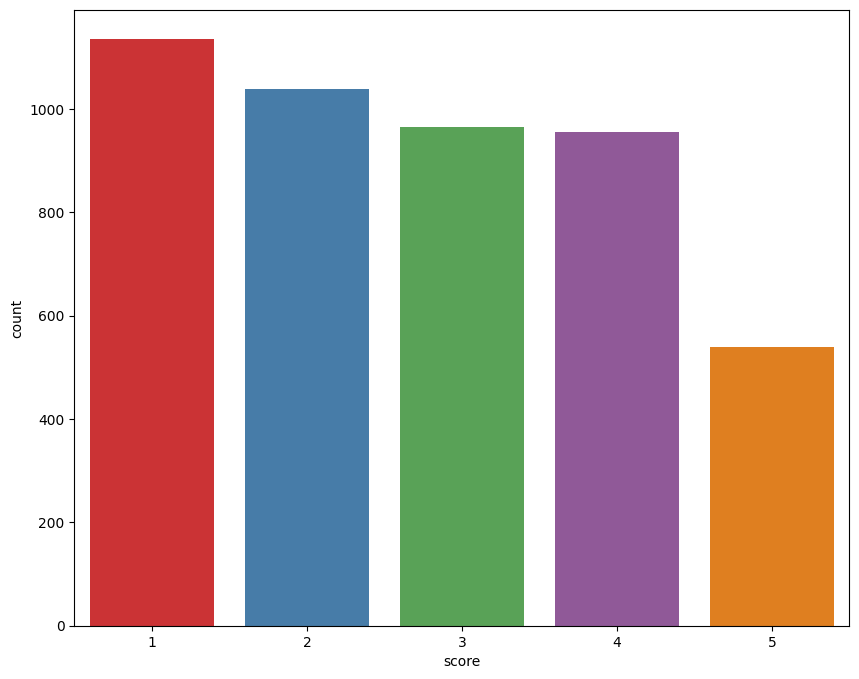

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(x="score",data=df,palette="Set1")
plt.show()

In [14]:
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'
    else:
        return 'Unknown'  
df['sentiment'] = df.score.apply(map_sentiment)

In [15]:
df["sentiment"].value_counts()

sentiment
Negative    2174
Positive    1494
Neutral      964
Name: count, dtype: int64

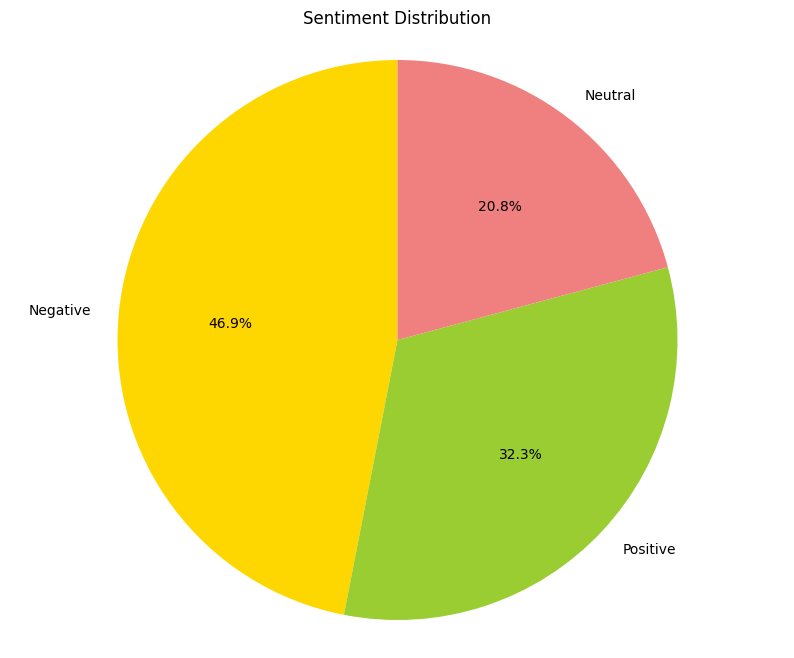

In [16]:
plt.figure(figsize=(10,8))
labels = df["sentiment"].value_counts().index
sizes = df["sentiment"].value_counts().values
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

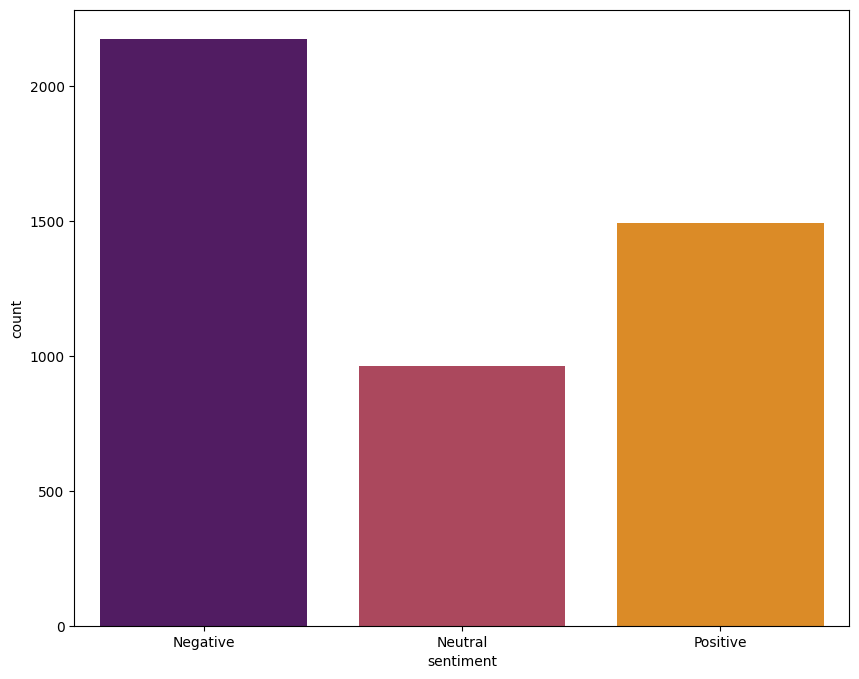

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(x="sentiment",data=df,palette="inferno")
plt.show()

In [18]:
df.drop(columns=["reviewId","userName","userImage","repliedAt","at"],axis=1,inplace=True)

In [19]:
df["thumbsUpCount"].value_counts()

thumbsUpCount
0      2693
1       638
2       295
3       179
4       110
       ... 
55        1
97        1
69        1
58        1
142       1
Name: count, Length: 113, dtype: int64

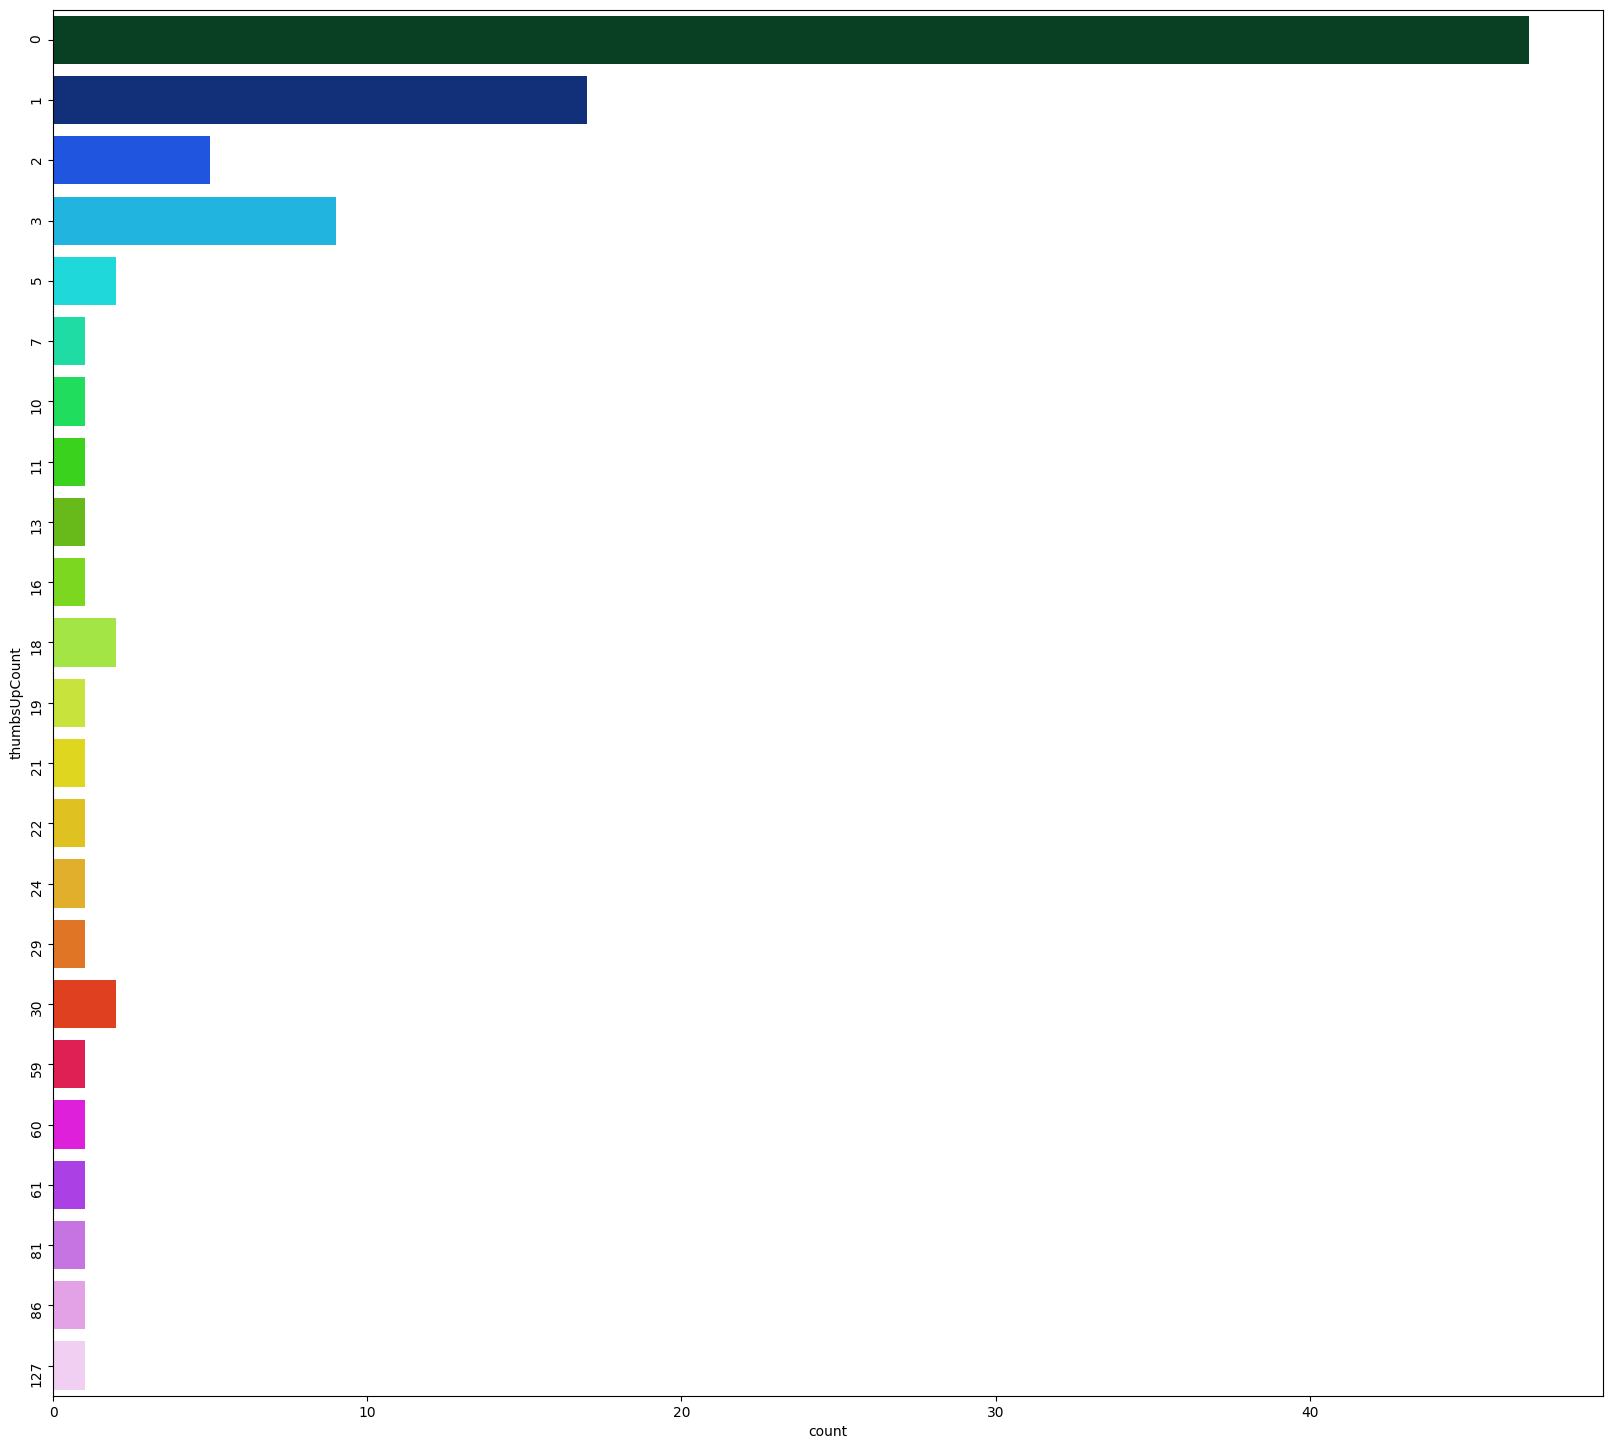

In [20]:
plt.figure(figsize=(20,18))
sns.countplot(y="thumbsUpCount",data=df[: 100],palette="gist_ncar")
plt.yticks(rotation=90)
plt.show()

In [21]:
df["sortOrder"].value_counts()

sortOrder
newest    4632
Name: count, dtype: int64

In [22]:
df["appId"].value_counts()

appId
com.tasks.android                555
com.gmail.jmartindev.timetune    526
com.anydo                        518
com.appgenix.bizcal              511
com.habitrpg.android.habitica    483
com.levor.liferpgtasks           478
cc.forestapp                     380
com.ticktick.task                276
com.todoist                      253
com.habitnow                     251
prox.lab.calclock                224
com.microsoft.todos              117
com.artfulagenda.app              47
com.appxy.planner                 11
com.oristats.habitbull             2
Name: count, dtype: int64

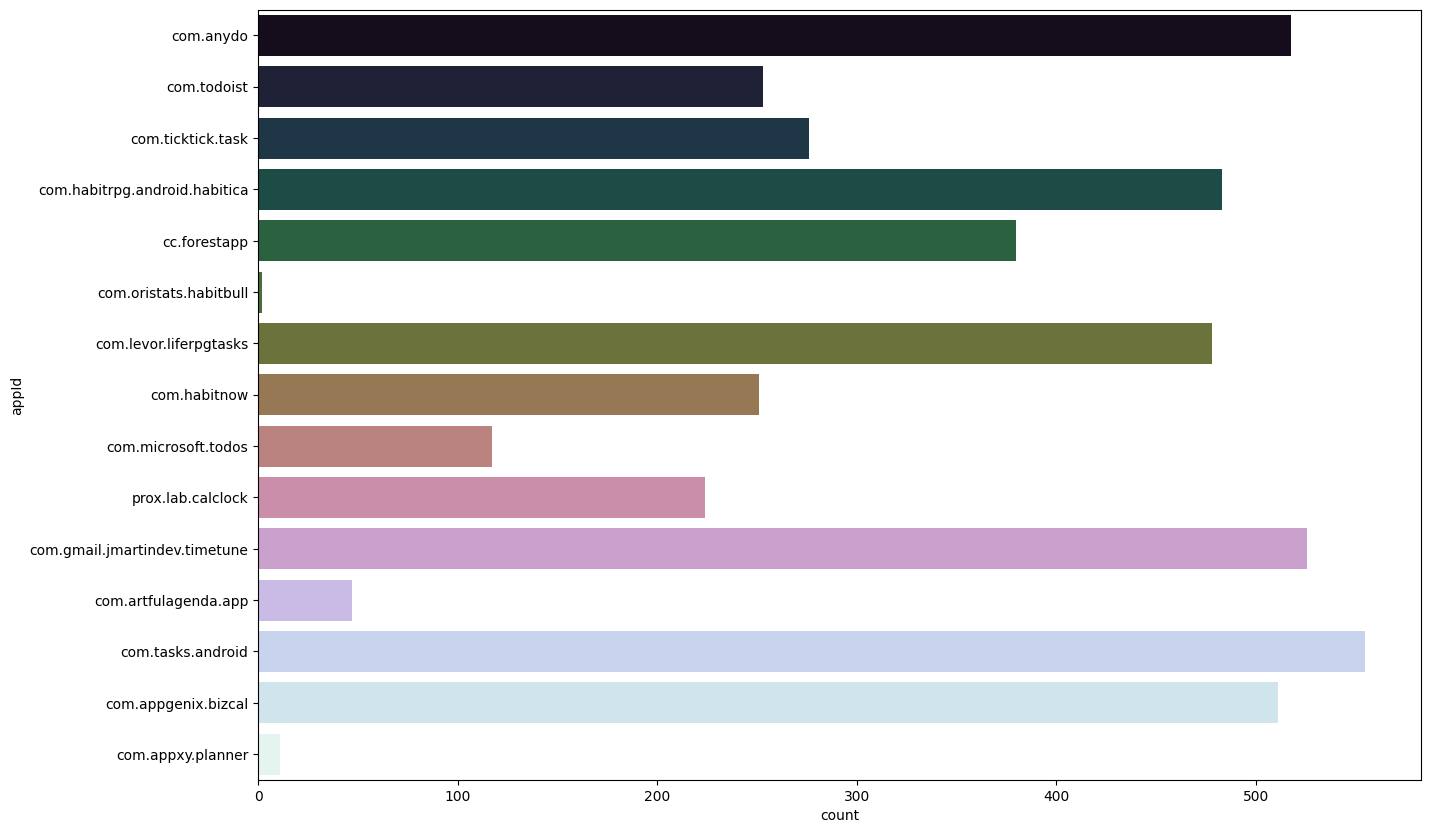

In [23]:
plt.figure(figsize=(15,10))
sns.countplot(y="appId",data=df,palette="cubehelix")
plt.show()

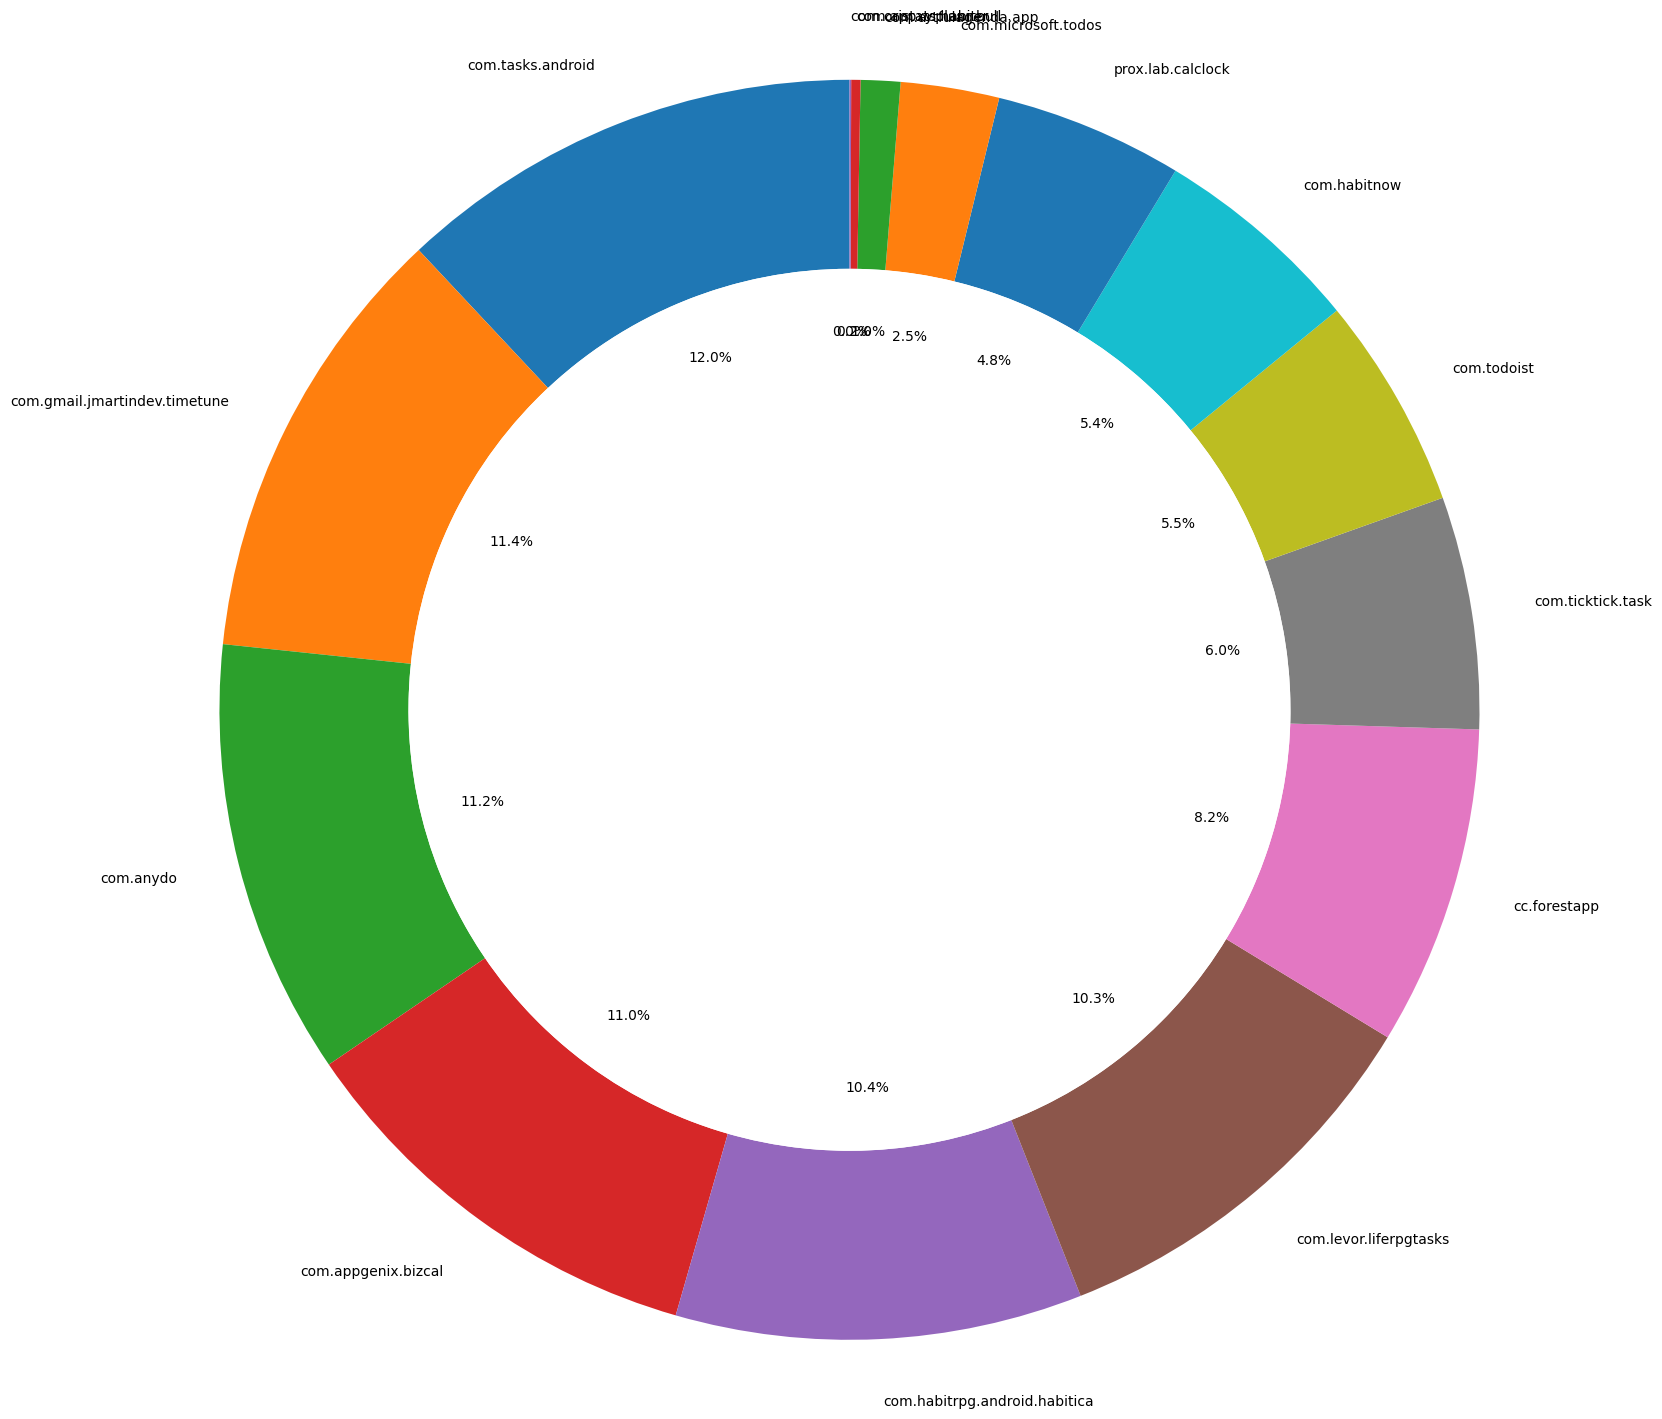

In [24]:
value_counts = df["appId"].value_counts()

fig, ax = plt.subplots(figsize=(20,18))

wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')

plt.show()

In [25]:
df.drop(columns=["score","thumbsUpCount","reviewCreatedVersion","sortOrder","appId"],axis=1,inplace=True)

In [26]:
df.rename(columns={'sentiment': 'label'}, inplace=True)

In [27]:
df["text"]=df["content"]+""+df["replyContent"]

In [28]:
df.drop(columns=["content","replyContent"],axis=1,inplace=True)

In [29]:
df=df[["text","label"]]

In [30]:
avg_len=df["text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 391.17


In [31]:
df.head()

,text,label
5,It has changed how I viewed my different lists...,Negative
6,I'm only looking for a grocery list app but ev...,Negative
7,"Reset my free trial, new phone I'd like to see...",Negative
8,How do to stop monthly payment because i don't...,Negative
9,I complain about not crashes and it was immedi...,Negative


# Negative Wordcloud

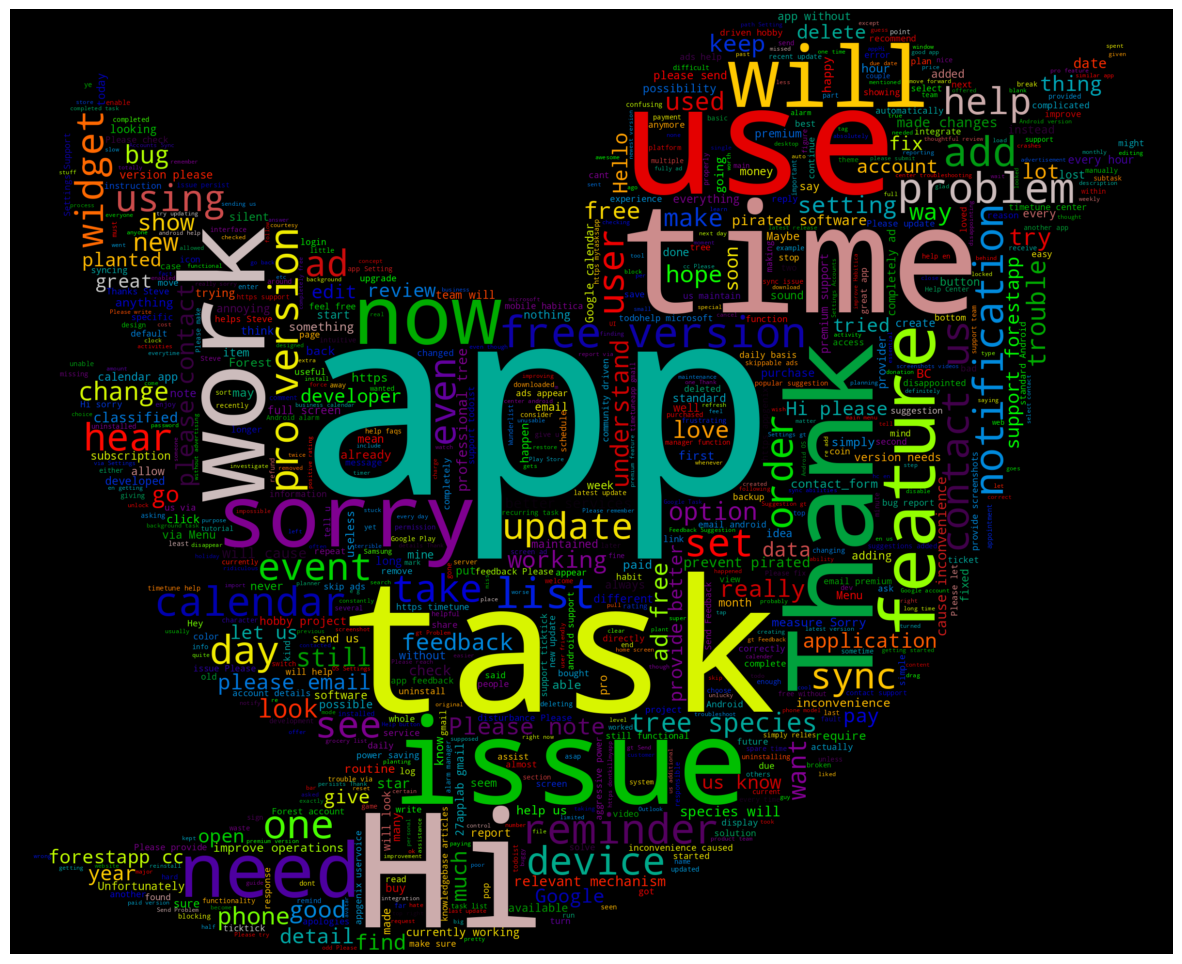

In [32]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(15,15))
negative_wordcloud=df[df["label"]=="Negative"]
negative_text=" ".join(negative_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="nipy_spectral",mask=mask).generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Positive Wordcloud

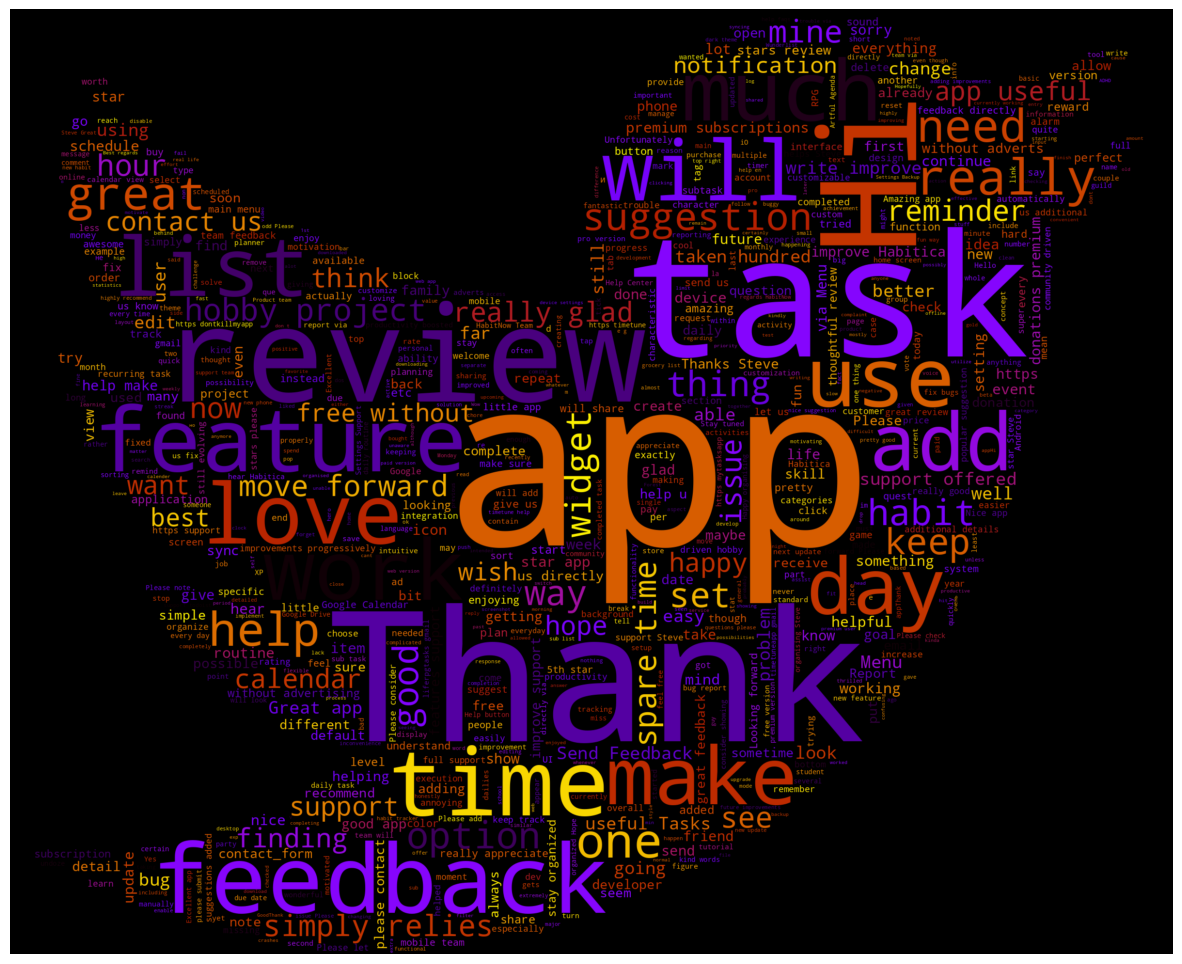

In [33]:
plt.figure(figsize=(15,15))
positive_wordcloud=df[df["label"]=="Positive"]
positive_text=" ".join(positive_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="gnuplot",mask=mask).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Neutral Wordcloud

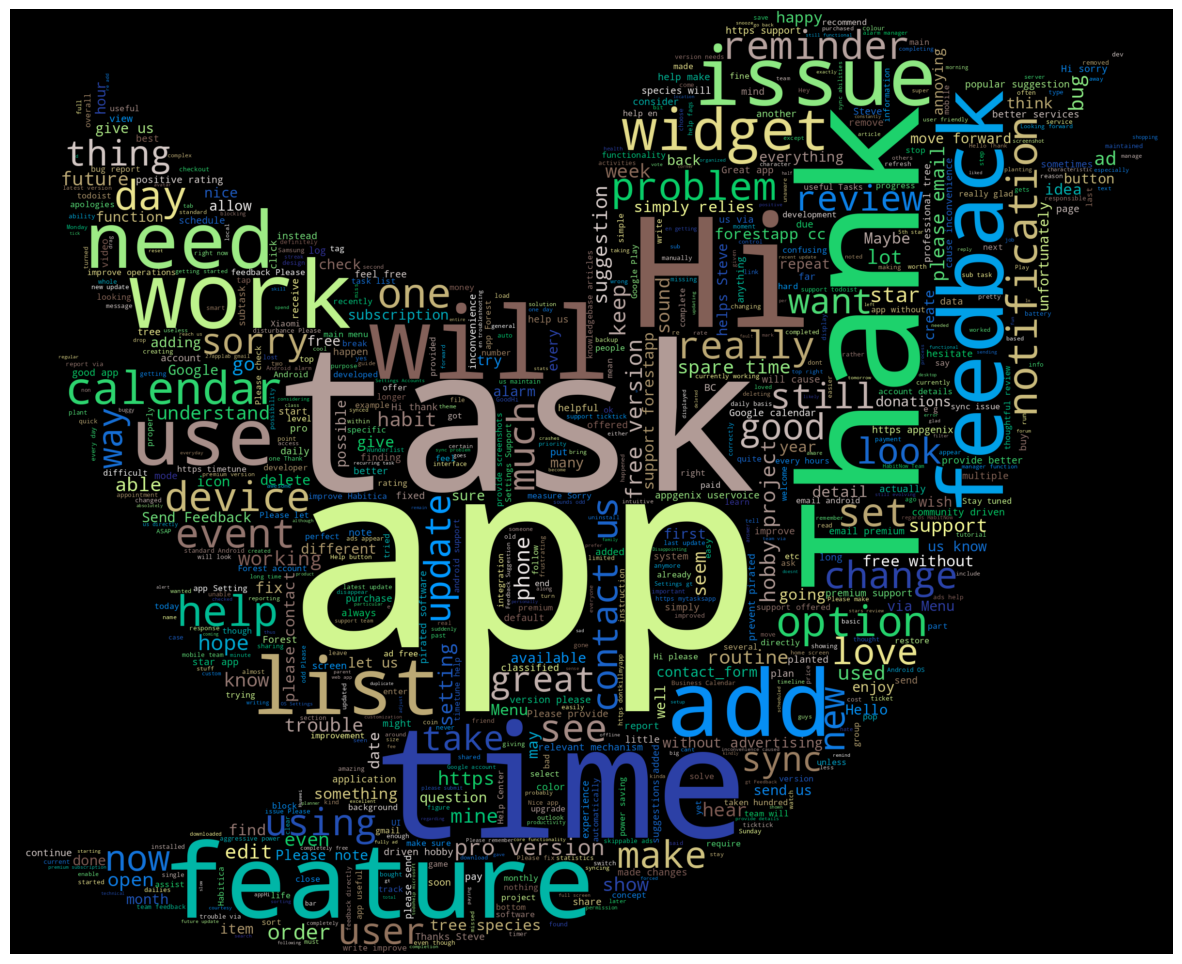

In [34]:
plt.figure(figsize=(15,15))
neutral_wordcloud=df[df["label"]=="Neutral"]
neutral_text=" ".join(neutral_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="terrain",mask=mask).generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 30 Most Common Words From Positive Text

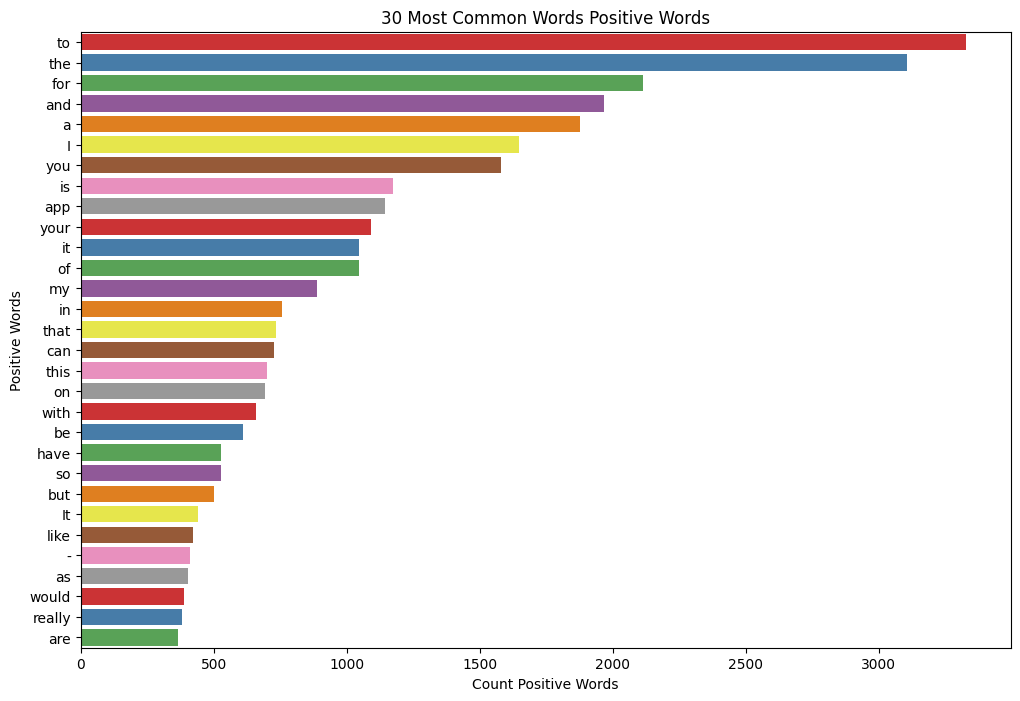

In [35]:
from collections import Counter

positive_text = df[df["label"] == "Positive"]
data_set = positive_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Set1")
plt.title('30 Most Common Words Positive Words')
plt.xlabel('Count Positive Words')
plt.ylabel('Positive Words')
plt.show()

# 30 Most Common Words From Negative Text

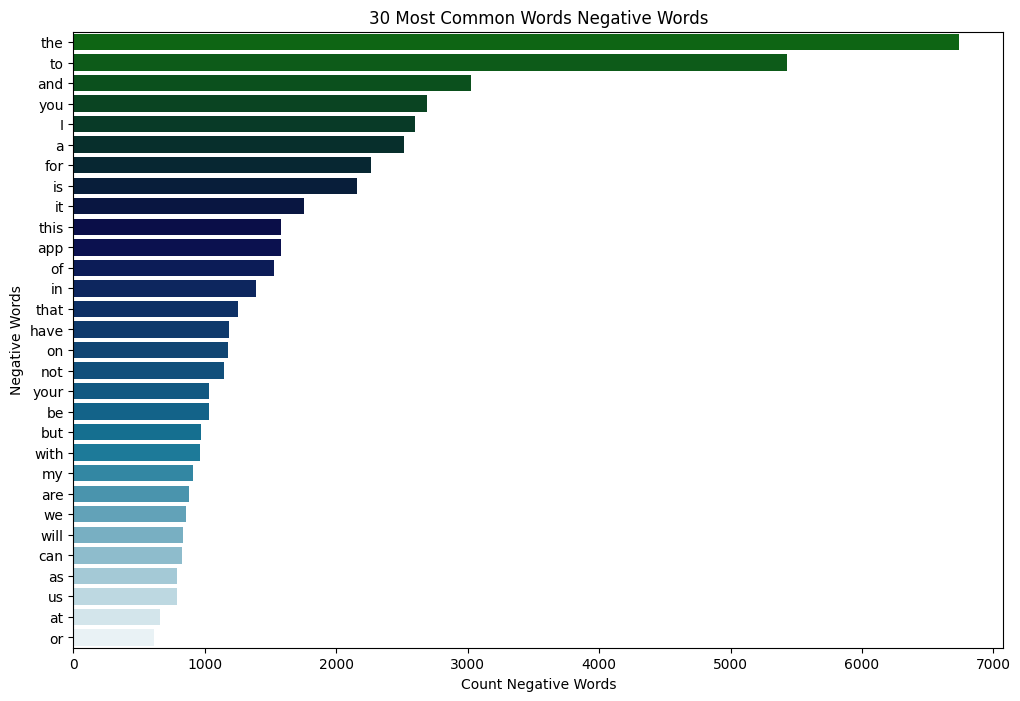

In [36]:
negative_text = df[df["label"] == "Negative"]
data_set = negative_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="ocean")
plt.title('30 Most Common Words Negative Words')
plt.xlabel('Count Negative Words')
plt.ylabel('Negative Words')
plt.show()

#  30 Most Common Words From Neutral Text

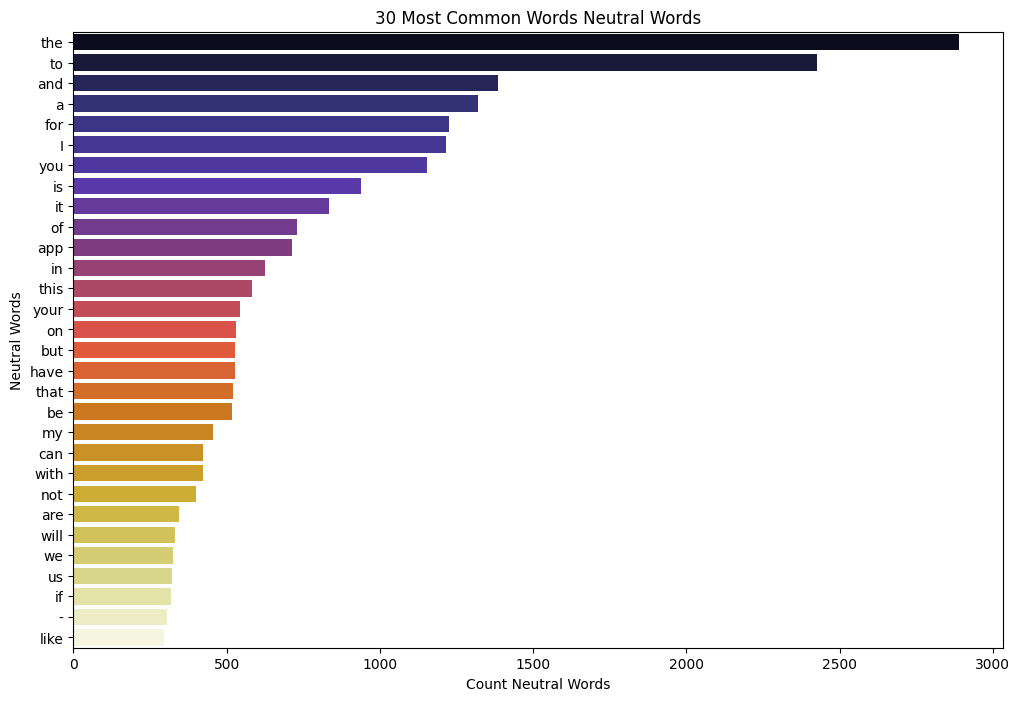

In [37]:
neutral_text = df[df["label"] == "Neutral"]
data_set = neutral_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="CMRmap")
plt.title('30 Most Common Words Neutral Words')
plt.xlabel('Count Neutral Words')
plt.ylabel('Neutral Words')
plt.show()

In [38]:
df["label"]=df["label"].replace({"Negative":0,"Positive":1,"Neutral":2})
class_names=["Negative","Positive","Neutral"]

In [39]:
df.head()

,text,label
5,It has changed how I viewed my different lists...,0
6,I'm only looking for a grocery list app but ev...,0
7,"Reset my free trial, new phone I'd like to see...",0
8,How do to stop monthly payment because i don't...,0
9,I complain about not crashes and it was immedi...,0


In [40]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [41]:
token_length=[]
for txt in df.text:
    tokens=tokenizer.encode(txt,max_length=512)
    token_length.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [42]:
len(token_length)

4632

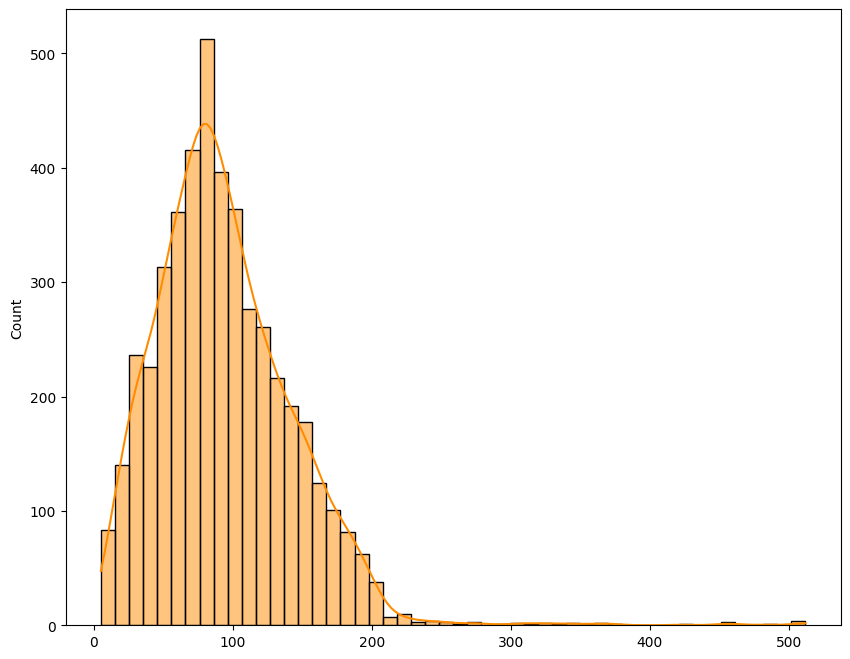

In [43]:
plt.figure(figsize=(10,8))
sns.histplot(token_length,color="darkorange",bins=50,kde=True)
plt.show()

In [44]:
max_len=210

# Prepare dataset

In [45]:
class Review(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [46]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [47]:
def data_loader(df, tokenizer, max_len, batch_size):
    prepare_data = Review(reviews=df.text.to_numpy(),
                          labels=df.label.to_numpy(),
                          tokenizer=tokenizer,
                          max_len=max_len)
    
    return DataLoader(prepare_data, batch_size=batch_size, num_workers=0)

In [48]:
batch_size = 32
train_data_loader = data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = data_loader(df_test, tokenizer, max_len, batch_size)

In [49]:
data = next(iter(train_data_loader))
print(data.keys())



dict_keys(['review_text', 'input_ids', 'attention_mask', 'labels'])


In [50]:
print("===============================================")
print(data['input_ids'].shape)
print("===============================================")
print(data['attention_mask'].shape)
print("===============================================")
print(data['labels'].shape)
print("===============================================")

torch.Size([32, 210])
torch.Size([32, 210])
torch.Size([32])


In [51]:
bert_model=BertModel.from_pretrained('bert-base-uncased')

# Create Sentiment Classifier

In [52]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
    def __init__(self, number_class):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, number_class)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # The second element is the pooled output
        
        output = self.drop(pooled_output)
        return self.out(output)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)


In [53]:
print(model.bert.config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [54]:
optimizer = optim.Adamax(model.parameters(), lr=0.00001)
epochs = 15
total_steps = len(train_data_loader) * epochs
criterion = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [55]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, example):
    model.train()
    losses = []
    prediction = 0

    train_epoch_iterator = tqdm(data_loader, desc="Training", leave=False)
    
    for i in train_epoch_iterator:
        input_ids = i["input_ids"].to(device)
        attention_mask = i["attention_mask"].to(device)
        labels = i["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        prediction += torch.sum(pred == labels)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        train_epoch_iterator.set_postfix(loss=np.mean(losses))
        
    return prediction.double() / example, np.mean(losses)

In [56]:
def eval_model(model, data_loader, criterion, device, example):
    model.eval()
    losses = []
    prediction = 0

    val_epoch_iterator = tqdm(data_loader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for x in val_epoch_iterator:
            input_ids = x["input_ids"].to(device)
            attention_mask = x["attention_mask"].to(device)
            labels = x["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            loss = criterion(outputs, labels)
            prediction += torch.sum(preds == labels)
            losses.append(loss.item())
            val_epoch_iterator.set_postfix(loss=np.mean(losses))
            
    return prediction.double() / example, np.mean(losses)

In [57]:
history = defaultdict(list)

for epoch in range(epochs):
    print(f"Epoch : {epoch+1}/{epochs}")
    print("-" * 15)
    
    train_acc, train_loss = train_epoch(model, train_data_loader, criterion, optimizer, device, scheduler, len(df_train))
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    val_acc, val_loss = eval_model(model, val_data_loader, criterion, device, len(df_val))
    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epoch : 1/15
---------------


Train loss 1.006871102698918 accuracy 0.5295546558704454


Val loss 0.9258666475613911 accuracy 0.6414686825053996

Epoch : 2/15
---------------


Train loss 0.8605404403702966 accuracy 0.6591093117408907


Val loss 0.8171136299769084 accuracy 0.6673866090712743

Epoch : 3/15
---------------


Train loss 0.7788917974665247 accuracy 0.691497975708502


Val loss 0.7686885595321655 accuracy 0.6911447084233262

Epoch : 4/15
---------------


Train loss 0.7127551289981809 accuracy 0.715519568151147


Val loss 0.7425905068715414 accuracy 0.6976241900647948

Epoch : 5/15
---------------


Train loss 0.6782526052717505 accuracy 0.7209176788124156


Val loss 0.733161449432373 accuracy 0.7105831533477323

Epoch : 6/15
---------------


Train loss 0.6454349658612547 accuracy 0.7468286099865047


Val loss 0.7294431646664937 accuracy 0.695464362850972

Epoch : 7/15
---------------


Train loss 0.6203287369732199 accuracy 0.7511470985155195


Val loss 0.729213539759318 accuracy 0.695464362850972

Epoch : 8/15
---------------


Train loss 0.6010286484299034 accuracy 0.7565452091767881


Val loss 0.7292439341545105 accuracy 0.7041036717062635

Epoch : 9/15
---------------


Train loss 0.5853437778764757 accuracy 0.7703103913630229


Val loss 0.7355193734169007 accuracy 0.6997840172786177

Epoch : 10/15
---------------


Train loss 0.5636267338333458 accuracy 0.7835357624831308


Val loss 0.72969970703125 accuracy 0.695464362850972

Epoch : 11/15
---------------


Train loss 0.5513787983820356 accuracy 0.7865047233468285


Val loss 0.7385531783103942 accuracy 0.6976241900647948

Epoch : 12/15
---------------


Train loss 0.5523369754182881 accuracy 0.7870445344129554


Val loss 0.7400552709897359 accuracy 0.6976241900647948

Epoch : 13/15
---------------


Train loss 0.5381450586277863 accuracy 0.7959514170040486


Val loss 0.7419635574022929 accuracy 0.695464362850972

Epoch : 14/15
---------------


Train loss 0.5271400174704092 accuracy 0.7997300944669365


Val loss 0.744426409403483 accuracy 0.695464362850972

Epoch : 15/15
---------------


Train loss 0.5266179591417313 accuracy 0.7970310391363022


Val loss 0.7473131537437439 accuracy 0.695464362850972



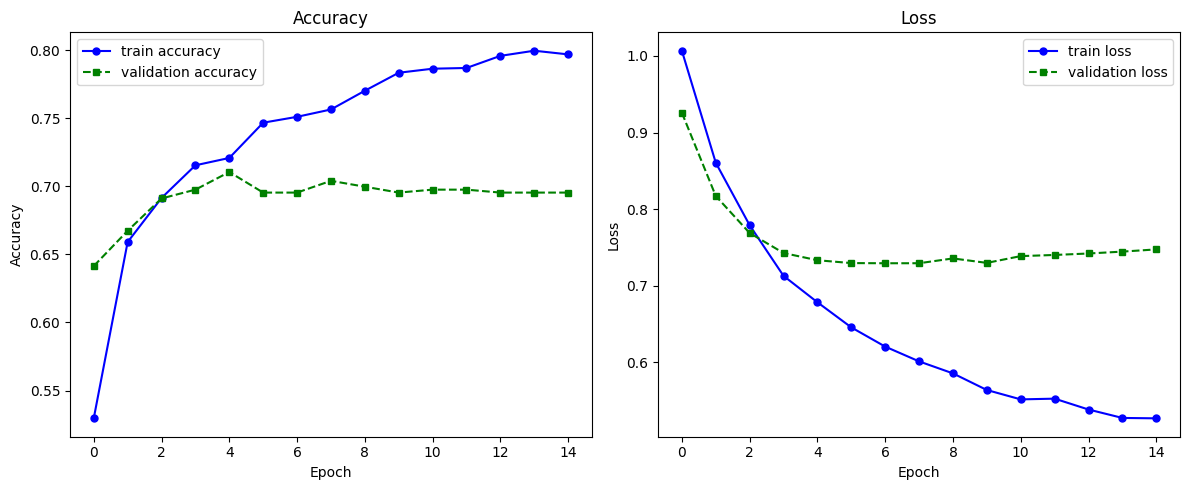

In [58]:

train_acc_np = np.array([t.cpu() for t in history['train_acc']])
val_acc_np = np.array([t.cpu() for t in history['val_acc']])
train_loss_np = np.array(history['train_loss'])
val_loss_np = np.array(history['val_loss'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_acc_np, label='train accuracy', linestyle='-', marker='o', color='blue', markersize=5)
ax1.plot(val_acc_np, label='validation accuracy', linestyle='--', marker='s', color='green', markersize=5)
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(train_loss_np, label='train loss', linestyle='-', marker='o', color='blue', markersize=5)
ax2.plot(val_loss_np, label='validation loss', linestyle='--', marker='s', color='green', markersize=5)
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

# Test Model Performance

In [59]:
test_acc,_=eval_model(model,test_data_loader,criterion,device,len(df_test))
test_acc.item()

0.7241379310344828

In [60]:
def my_prediction(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []  # Initialize prediction_probs here
    real_values = []

    with torch.no_grad():
        for x in data_loader:
            texts = x["review_text"]
            input_ids = x["input_ids"].to(device)
            attention_mask = x["attention_mask"].to(device)
            labels = x["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)  # Use the initialized prediction_probs
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

y_review_text, y_pred, y_proba, y_test = my_prediction(model, test_data_loader)

In [61]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.76      0.87      0.81       233
    Positive       0.79      0.80      0.80       140
     Neutral       0.39      0.24      0.30        91

    accuracy                           0.72       464
   macro avg       0.65      0.64      0.63       464
weighted avg       0.70      0.72      0.71       464



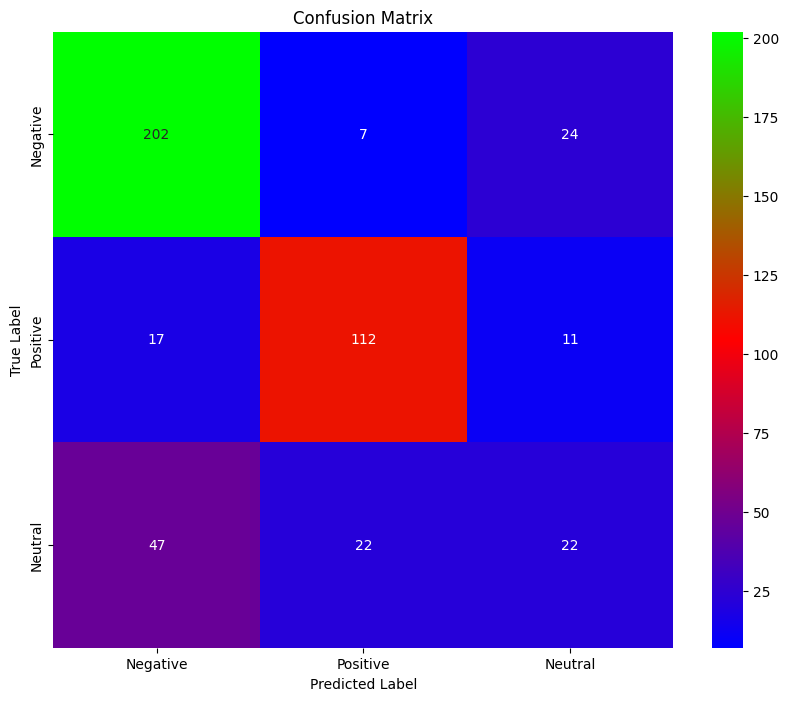

In [62]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=class_names,yticklabels=class_names,cmap="brg")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

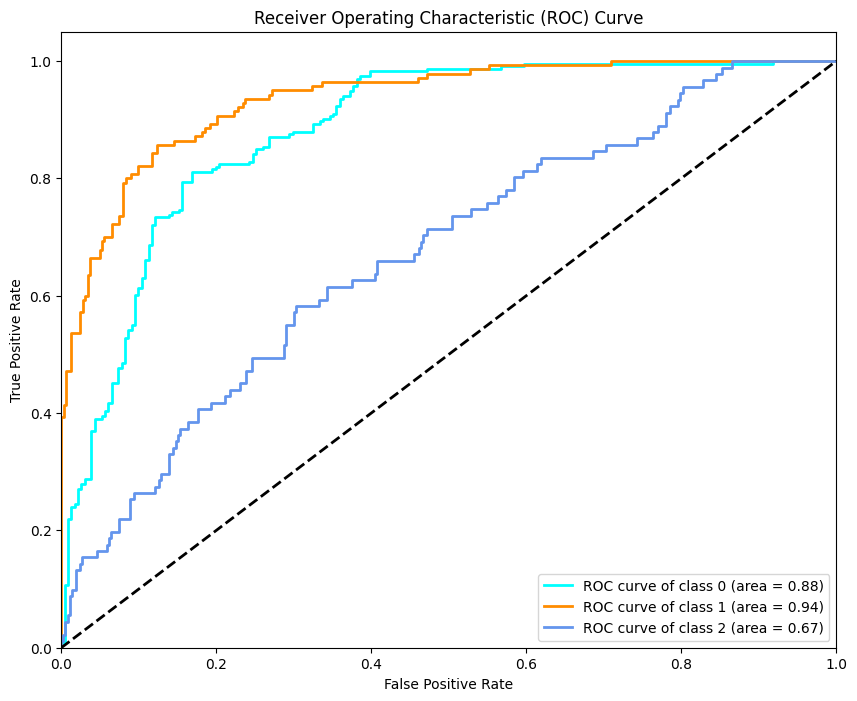

In [63]:
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])


plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

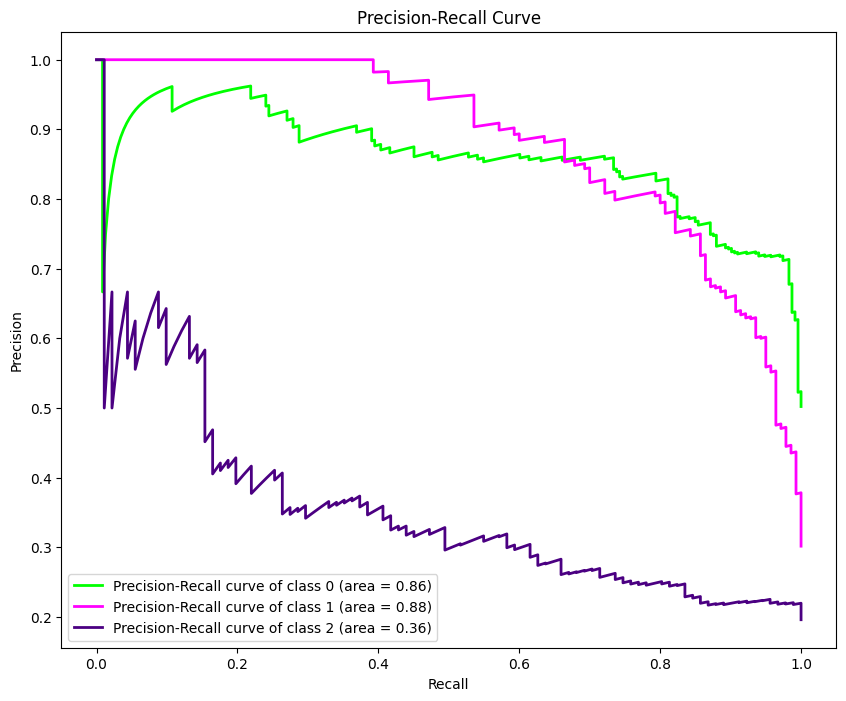

In [64]:
from sklearn.metrics import precision_recall_curve, average_precision_score
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)


precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])


plt.figure(figsize=(10, 8))
colors = ['lime', 'magenta', 'indigo']

for i, color in zip(range(len(classes)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'''.format(classes[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Prediction On Custom Data

In [65]:
test_text="The project failed to meet the deadline due to inadequate planning and poor execution"
check_custom_data=tokenizer.encode_plus(test_text,max_length=max_len,add_special_tokens=True,return_token_type_ids=False,
                                       pad_to_max_length=True,return_attention_mask=True,return_tensors="pt")
input_ids = check_custom_data['input_ids'].to(device)
attention_mask = check_custom_data['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print("====================================================================================================================")
print("Custom Text For Prediction ===> {}".format(test_text))
print("====================================================================================================================")
print("Prediction Result Is ===> {}".format(class_names[prediction]))
print("====================================================================================================================")

Custom Text For Prediction ===> The project failed to meet the deadline due to inadequate planning and poor execution
Prediction Result Is ===> Neutral
